In [23]:
import pandas as pd
import numpy as np
import re
from scipy.integrate import odeint

# Read the data in, then select the relevant columns, and adjust the week so it is easier to realize
# as a time series.
virii = ["A (H1)", "A (H3)", "A (Subtyping not Performed)", "B"]
virus = "B"
file = "data/2007-2008_Region-5_WHO-NREVSS.csv"
fluData = pd.read_csv(file)[["YEAR", "WEEK", "TOTAL SPECIMENS"] + virii]
firstWeek = fluData["WEEK"][0]
fluData["T"] = fluData["WEEK"] + 52 * (fluData["WEEK"] < firstWeek)
fluData = fluData.drop(["YEAR", "WEEK"], axis=1)

match = re.match("^data/(\d+-\d+)_Region-(\d+)_.*", file)
title = "Flu Season " + match[1] + " for HHS Region " + match[2]

Text(0, 0.5, 'Infected Individuals')

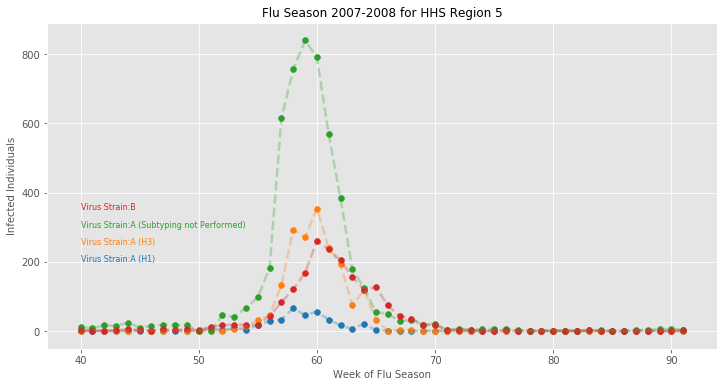

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.xkcd()
plt.style.use('ggplot')
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

plt.figure(figsize=(12,6)) 

for idx in [0, 1, 2, 3]:
    plt.plot(fluData['T'], fluData[virii[idx]], ls="--", lw=2.5, color=tableau20[idx*2], alpha=0.3)
    plt.scatter(fluData['T'], fluData[virii[idx]], color=tableau20[idx*2])
    y_pos = 200 + idx*50
    plt.text(40, y_pos, "Virus Strain:" + virii[idx], fontsize=8, color=tableau20[idx*2]) 
    
plt.title(title, fontsize=12)
plt.xlabel("Week of Flu Season", fontsize=10)
plt.ylabel("Infected Individuals", fontsize=10)